在输入中加入了时间特征

In [1]:
%config InlineBackend.figure_format = 'retina'

from utils.utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import keras
from keras.layers import Dense, LSTM, Dropout, Activation, GRU
from keras.models import Sequential

Using TensorFlow backend.


# 高峰分析

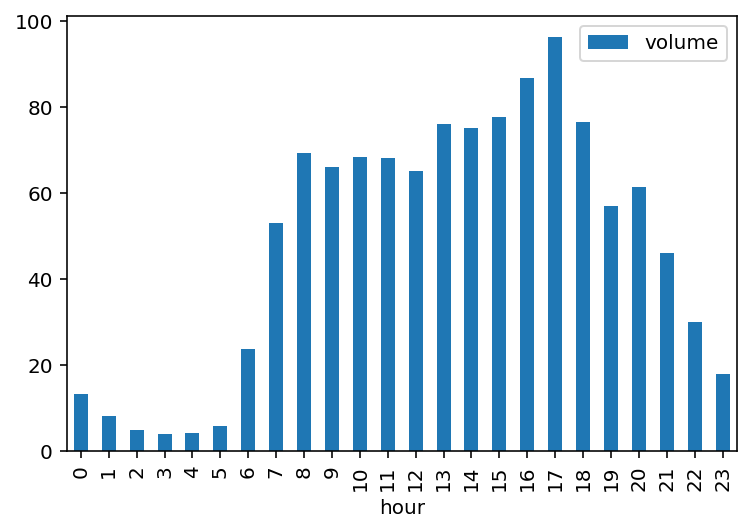

In [108]:
ts = get_flow_series_by_idx(0)
df = pd.DataFrame(ts)
df['hour'] = pd.Series(df.index, index=df.index).apply(lambda x: x.hour)
df['wkday'] = pd.Series(df.index, index=df.index).apply(lambda x: x.weekday())
df.groupby('hour').mean().plot(kind='bar', y='volume')  # 13 - 18 为高峰

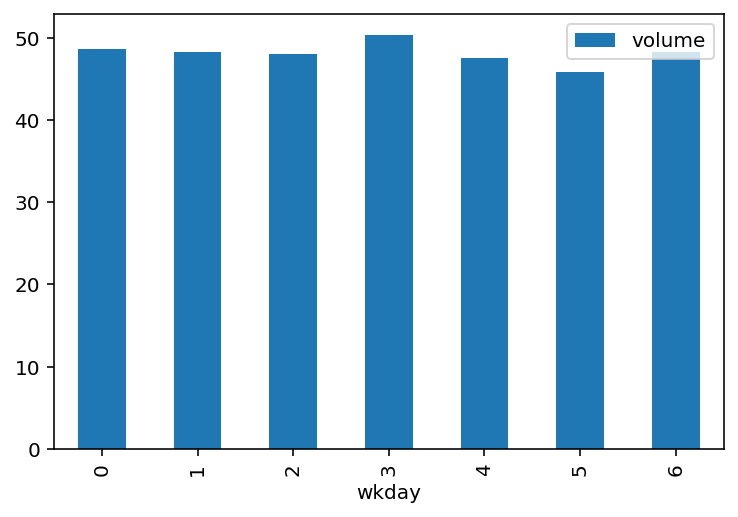

In [110]:
df.groupby('wkday').mean().plot(kind='bar', y='volume')  # 没有太明显的差异

# 加入高峰信息

In [111]:
ts = get_flow_series_by_idx(0)
ts = ts.resample('15min').sum()  # 15min粒度

def get_period(x):
    hr = x.hour
    return 1 if 13<=hr<=18 else 0
ts_period = pd.Series(ts.index).apply(get_period)

scaler = StandardScaler()
ts = scaler.fit_transform(ts.values.reshape(-1,1))  # z-score normalize
ts_period = StandardScaler().fit_transform(ts_period.values.reshape(-1,1))

timesteps = 7  # 时间步
test_size = 4*24*7  # 最后7天为测试集

x1, y = get_x_y_by_sliding_window(ts, in_steps=timesteps, out_steps=1)
x2, _ = get_x_y_by_sliding_window(ts_period, in_steps=timesteps, out_steps=1)
x = np.concatenate([x1,x2], axis=-1)
y = y.sum(axis=-2)  # 无论输出时间步是不是1，都要进行这项操作

x_train, y_train, x_test, y_test = split_train_test(x, y, test_size=test_size)

In [112]:
x_train.shape

(2201, 7, 2)

In [114]:
model = Sequential()
model.add(LSTM(128, input_shape=(timesteps,2),return_sequences=True, activation='relu'))
model.add(LSTM(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse')
history = model.fit(x=x_train, y=y_train, epochs=256, batch_size=256, validation_split=0.1, verbose=0)

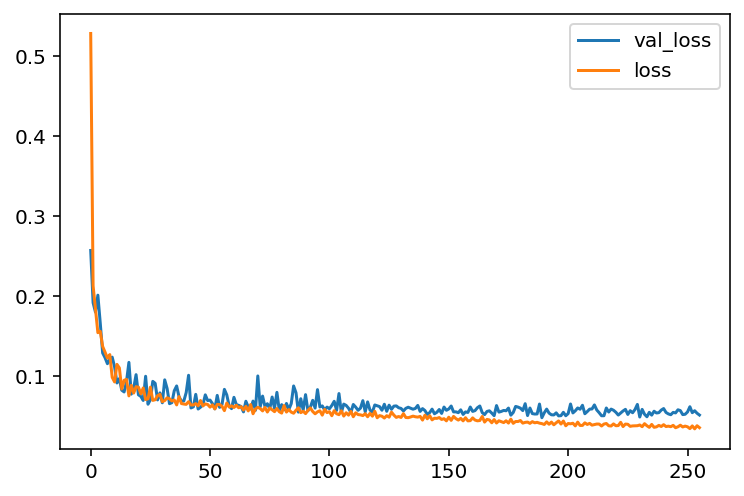

In [115]:
for k, v in history.history.items():
    plt.plot(v, label=k)
plt.legend()

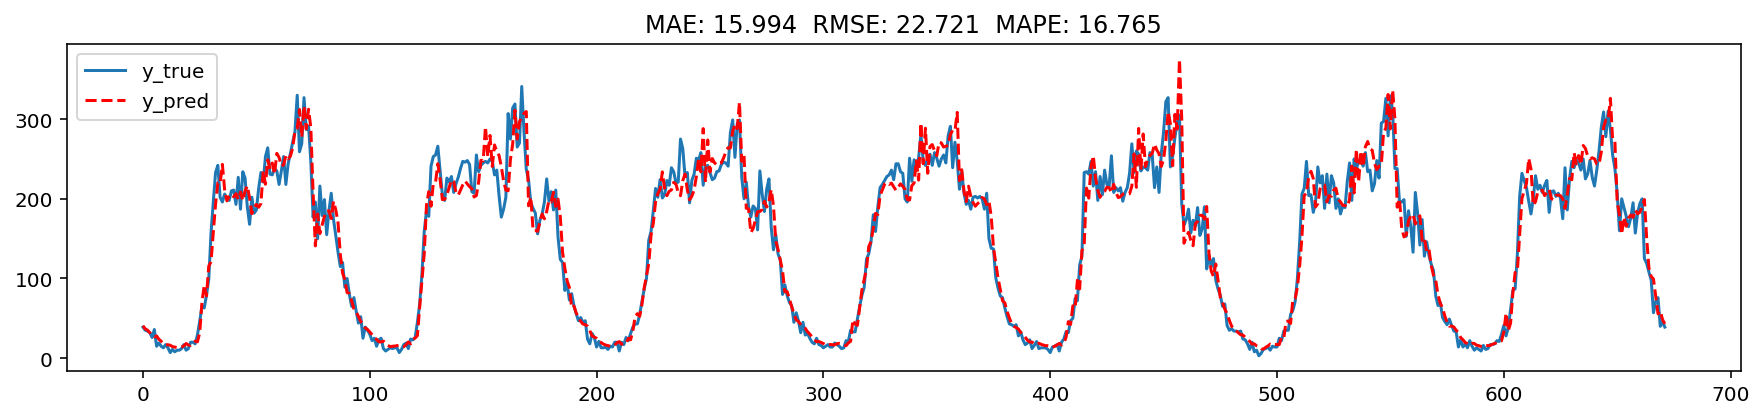

In [116]:
test_model(model, x_test, y_test, scaler=scaler, plot_with_figsize=(15,3))

# 引入去趋势

## 原始流量+残差+是否高峰->残差

In [117]:
timesteps = 7  # 时间步
test_size = 4*24*7  # 最后7天为测试集

ts = get_flow_series_by_idx(0)
ts = ts.resample('15min').sum()

scaler = StandardScaler()
arr = scaler.fit_transform(ts.values.reshape(-1,1))  # z-score normalize
ts = pd.Series(arr.reshape(-1), index=ts.index)  # 原始时间序列

df = pd.DataFrame(ts).reset_index()
df['trend_idx'] = df.datetime.apply(lambda x:str((x.weekday(),x.hour, x.minute)))
trend_df = df.iloc[0:-test_size].groupby('trend_idx').mean()  # 仅使用训练集的趋势
df['trend'] = df.trend_idx.apply(lambda x: trend_df.loc[x])

def get_period(x):
    hr = x.hour
    return 1 if 13<=hr<=18 else 0
ts_period = pd.Series(ts.index).apply(get_period)
trend_ts = df.set_index('datetime')['trend']
residual_ts = ts - trend_ts  # 残差时间序列

ts_period = StandardScaler().fit_transform(ts_period.values.reshape(-1,1))

x_trend, y_trend = get_x_y_by_sliding_window(trend_ts, in_steps=timesteps, out_steps=1)
y_trend = y_trend.sum(axis=-2)

x_residual, y_residual = get_x_y_by_sliding_window(residual_ts, in_steps=timesteps, out_steps=1)
y_residual = y_residual.sum(axis=-2)

x_org, y_org = get_x_y_by_sliding_window(ts, in_steps=timesteps, out_steps=1)
y_org = y_org.sum(axis=-2)

x_period, y_period = get_x_y_by_sliding_window(ts_period, in_steps=timesteps, out_steps=1)


# x为输入时间步的流量与残差
# y为下一时刻的流量
x = np.concatenate([x_org, x_residual, x_period], axis=-1)
y = y_residual

x_train, y_train, x_test, y_test = split_train_test(x, y, test_size=test_size)

In [118]:
x_train.shape, y_train.shape

((2201, 7, 3), (2201, 1))

In [119]:
model = Sequential()
model.add(LSTM(128, input_shape=(timesteps,3),return_sequences=True, activation='relu'))
model.add(LSTM(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse')
history = model.fit(x=x_train, y=y_train, epochs=256, batch_size=256, validation_split=0.1, verbose=0)

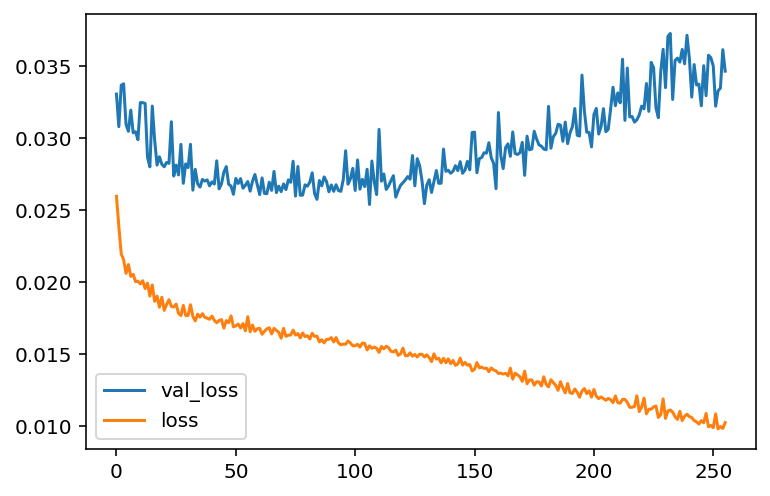

In [120]:
for k, v in history.history.items():
    plt.plot(v, label=k)
plt.legend()

{'mae': 16.68748230735461,
 'rmse': 23.667544036531215,
 'mape': 16.078659673860315}

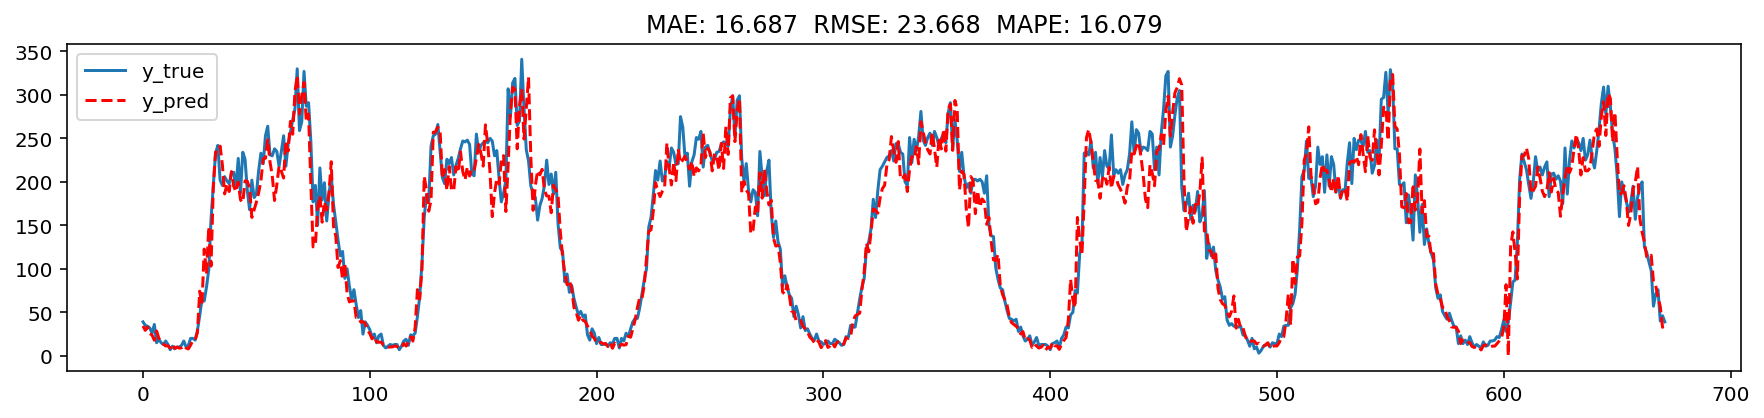

In [121]:
y_pred = model.predict(x_test)  # 残差预测值
y_pred += y_trend[-test_size:]  # 残差 + 趋势 = 时间序列
y_pred = scaler.inverse_transform(y_pred)
y_pred[y_pred<0] = 0
y_true = y_org[-test_size:]  # 时间序列真实值
y_true = scaler.inverse_transform(y_true)

test_y_pred(y_true, y_pred, plot_with_figsize=(15,3))

## 原始流量+残差+是否高峰->真实流量

In [122]:
timesteps = 7  # 时间步
test_size = 4*24*7  # 最后7天为测试集

ts = get_flow_series_by_idx(0)
ts = ts.resample('15min').sum()

scaler = StandardScaler()
arr = scaler.fit_transform(ts.values.reshape(-1,1))  # z-score normalize
ts = pd.Series(arr.reshape(-1), index=ts.index)  # 原始时间序列

df = pd.DataFrame(ts).reset_index()
df['trend_idx'] = df.datetime.apply(lambda x:str((x.weekday(),x.hour, x.minute)))
trend_df = df.iloc[0:-test_size].groupby('trend_idx').mean()  # 仅使用训练集的趋势
df['trend'] = df.trend_idx.apply(lambda x: trend_df.loc[x])

def get_period(x):
    hr = x.hour
    return 1 if 13<=hr<=18 else 0
ts_period = pd.Series(ts.index).apply(get_period)
trend_ts = df.set_index('datetime')['trend']
residual_ts = ts - trend_ts  # 残差时间序列

ts_period = StandardScaler().fit_transform(ts_period.values.reshape(-1,1))

x_trend, y_trend = get_x_y_by_sliding_window(trend_ts, in_steps=timesteps, out_steps=1)
y_trend = y_trend.sum(axis=-2)

x_residual, y_residual = get_x_y_by_sliding_window(residual_ts, in_steps=timesteps, out_steps=1)
y_residual = y_residual.sum(axis=-2)

x_org, y_org = get_x_y_by_sliding_window(ts, in_steps=timesteps, out_steps=1)
y_org = y_org.sum(axis=-2)

x_period, y_period = get_x_y_by_sliding_window(ts_period, in_steps=timesteps, out_steps=1)


# x为输入时间步的流量与残差
# y为下一时刻的流量
x = np.concatenate([x_org, x_residual, x_period], axis=-1)
y = y_org

x_train, y_train, x_test, y_test = split_train_test(x, y, test_size=test_size)

In [123]:
x_train.shape, y_train.shape

((2201, 7, 3), (2201, 1))

In [124]:
model = Sequential()
model.add(LSTM(128, input_shape=(timesteps,3),return_sequences=True, activation='relu'))
model.add(LSTM(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse')
history = model.fit(x=x_train, y=y_train, epochs=256, batch_size=256, validation_split=0.1, verbose=0)

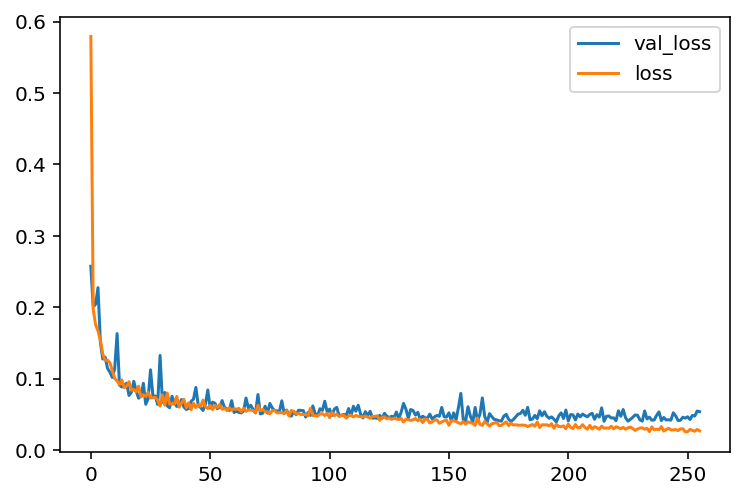

In [125]:
for k, v in history.history.items():
    plt.plot(v, label=k)
plt.legend()

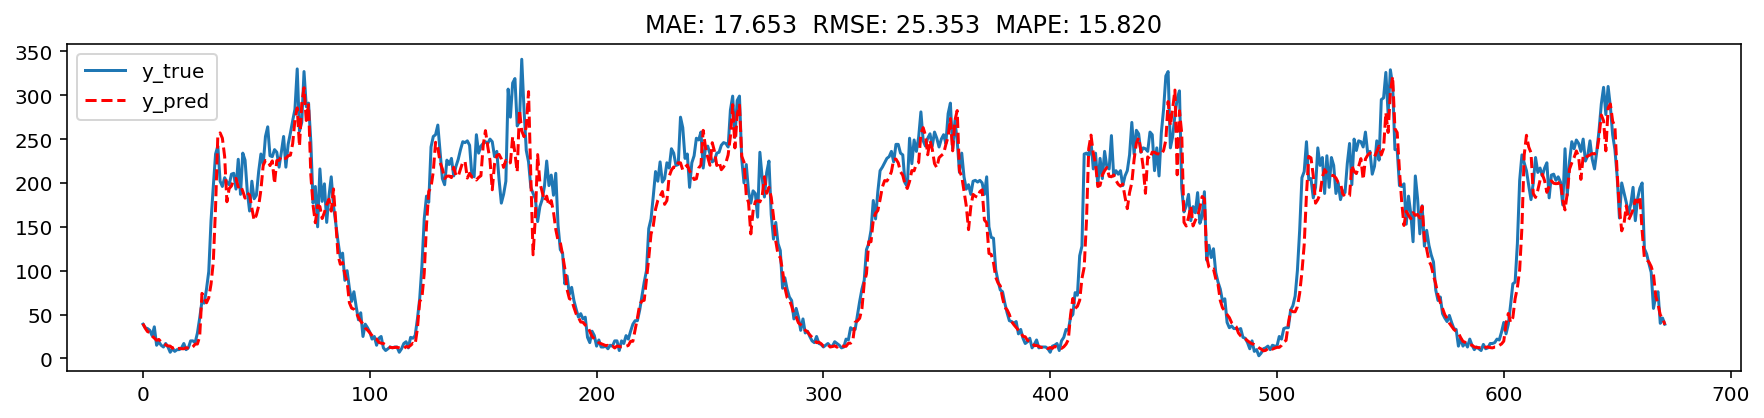

In [126]:
test_model(model, x_test, y_test, scaler=scaler, plot_with_figsize=(15,3))